In [387]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import calendar
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import warnings


## Loading Data

There are five different datasets available from a local restaurant.

- daywise_sales_data: Includes the sales including date, invoice of order, sales amount and more.
- daywise_item_data: Includes: Item name along with order date.
- Itemwise_report: Includes Items sales along with Invoice number and datetime.
- All_items_sales_data: Categorywise Distribution of Items and its details. 
- Online_slaes_data: Includes details of Online Order.

In [389]:
daywise_sales_data=pd.read_excel("/content/drive/MyDrive/Data Analytics on Restaurant/Day_wise_Summary_Aug20May21.xlsx")
daywise_sales_data.head()

,Date,Orders,Invoice Nos.,My Amount (₹),Discount (₹),Delivery Charge,Container Charge,Service Charge,Total Tax (₹),Round Off,Waived off,Total (₹),Non Taxable,Delivery Orders,Delivery,Pick Up Orders,Pick Up,Dine In Orders,Dine In,Cash,Card,Due Payment,Other [phone pay],Other [amazon pay],Other [google pay],Other [online],Other [paytm],Wallet [Paytm Wallet],Wallet [UPI],Expenses
0,Total,4348.00,NaN,798329.00,6277.50,990.00,25171.00,0,0,4.50,-63.00,818154,792051.49,153.00,50344.00,1591.00,249848.00,2604.00,517962.00,677250.00,0,0,14141.00,0,3901.00,0,122862.00,0,0,0
1,Min.,1.00,NaN,515.00,0.00,0.00,0.00,0,0,0.00,0.00,525,515.00,0.00,0.00,0.00,0.00,0.00,0.00,135.00,0,0,0.00,0,0.00,0,0.00,0,0,0
2,Max.,38.00,NaN,8695.00,845.00,100.00,420.00,0,0,0.50,0.00,8274,8010.00,5.00,1625.00,25.00,4199.00,25.00,5835.00,7525.00,0,0,825.00,0,585.00,0,3773.00,0,0,0
3,Avg.,15.64,NaN,2871.69,22.58,3.56,90.54,0,0,0.02,-0.23,2943,2849.11,0.55,181.09,5.72,898.73,9.37,1863.17,2436.15,0,0,50.87,0,14.03,0,441.95,0,0,0
4,2020-08-10,6.00,26-31,2025.00,113.25,0.00,0.00,0,0,0.25,0.00,1912,1911.75,1.00,216.00,1.00,45.00,4.00,1651.00,1085.00,0,0,0.00,0,0.00,0,827.00,0,0,0


In [390]:
daywise_item_data=pd.read_excel("/content/drive/MyDrive/Data Analytics on Restaurant/Daywise_Item_Summary_2021_06_16_23_11_35.xlsx")
daywise_item=daywise_item_data.copy()
daywise_item_data.head()

,Item,Date,Qty.,Total (₹)
0,Total,NaN,11348,798329
1,Masala Uttapam,2020-08-16,2,290
2,Onion Tomato Coconut Uttapam,2020-08-25,1,140
3,Mix Uttapam,2020-08-25,2,240
4,Idli,2020-08-10,2,100


In [391]:
Itemwise_report=pd.read_excel("/content/drive/MyDrive/Data Analytics on Restaurant/Item_Wise_Report_With_Bill_No._2021_06_16_23_16_08.xlsx")
Itemwise_report.head()

,Date,Date_and_time,Invoice,Items,Price,Quantity,Sub_total,Discount,Tax,Final Total,Table No.,Server Name,Covers,Variation,Category,HSN
0,Total,NaN,NaN,NaN,664165,11348,798329,6277.51,0,792051.49,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-31,2021-05-31 21:27:05,4398.0,Masala Dosa (Butter),115,2,230,0.00,0,230.00,4.0,biller,0.0,Butter,Dosa,NaN
2,2021-05-31,2021-05-31 21:27:05,4398.0,Mysore Masala Dosa (Butter),125,1,125,0.00,0,125.00,4.0,biller,0.0,Butter,Dosa,NaN
3,2021-05-31,2021-05-31 21:27:05,4398.0,Sprite,20,2,40,0.00,0,40.00,4.0,biller,0.0,NaN,Extra,NaN
4,2021-05-31,2021-05-31 21:27:05,4398.0,Butter Milk,20,1,20,0.00,0,20.00,4.0,biller,0.0,NaN,Beverages,NaN


In [392]:
All_items_sales_data=pd.read_excel("/content/drive/MyDrive/Data Analytics on Restaurant/Itemwise_Dining and Takeaway_Sales_August20-May21.xlsx")
All_items_sales_data.head()

,Category,Item,Qty,My Amount,Discount,Tax,Gross Sales,Sap Code
0,Beverages,Orange Juice,4,330,0.00,0,330.00,NaN
1,Beverages,Mosambi Juice,67,7585,2.56,0,7582.44,NaN
2,Beverages,Pineapple Juice,72,6040,1.98,0,6038.02,NaN
3,Beverages,Watermelon Juice,45,2700,4.40,0,2695.60,NaN
4,Beverages,Lemon Crush,57,2565,7.39,0,2557.61,NaN


In [393]:
Online_sales_data=pd.read_csv("/content/drive/MyDrive/Data Analytics on Restaurant/Zomato_ORDER_HISTORY_DATA2020-08-01_2021-05-31.csv")
Online_sales_data.head()

,Sno,Order Date,Delivery Status,Payment Method,Source,Amount (INR),Rejection Reason
0,1,"06:39 PM, May 28 2021",Delivered,Online,Zomato,842.0,NaN
1,2,"06:38 PM, May 28 2021",Delivered,Online,Zomato,210.0,NaN
2,3,"07:01 PM, May 26 2021",Delivered,Online,Zomato,356.0,NaN
3,4,"10:18 AM, May 26 2021",Delivered,Online,Zomato,190.0,NaN
4,5,"07:28 PM, May 25 2021",Rejected,Online,Zomato,176.0,| compensation = 40% of order value


## Data cleaning, Data Wrangling and Creating useful data

Removing unnecessary data and creating datsets for visualizations and forecasting.This section is divided into 3 sections.

1] Dataset for Sales Forecasting

2] Dataset for Association Rule Analysis

3] Datasets for Visualizations


#### 1] Dataset for Sales Forecasting
Total_Sales: It includes completed orders from both Online and Offline(includes dine-in, take away and delivery) data.

In [394]:
Online_sales_data['Order Date']=pd.to_datetime(Online_sales_data['Order Date'])
Online_sales_delivered=Online_sales_data[Online_sales_data['Delivery Status'] == 'Delivered']

In [395]:
Online_sales_delivered.drop(columns=['Delivery Status','Payment Method','Source','Rejection Reason'], axis=1, inplace=True)
Online_sales_delivered.rename(columns={'Amount (INR)':'Online_Payment'},inplace=True)
Online_sales_delivered.reset_index(inplace=True)
Online_sales_delivered.drop(columns=['index','Sno'],axis=1,inplace= True)

In [396]:
Online_sales_delivered
Online_sales_delivered_copy=Online_sales_delivered
# Creating a copy

In [397]:
datelist=Online_sales_delivered['Order Date']
date=pd.Series(datelist[i].date() for i in range(191))
Online_sales_delivered['Orders Date']=date
# Adding date column

In [398]:
Online_sales_delivered.drop('Order Date',axis=1,inplace=True)
Online_sales=Online_sales_delivered.groupby(['Orders Date']).agg({'Online_Payment':'sum'})
Online_sales.reset_index(inplace=True)
Online_sales.head()
# Offline Sales Data

,Orders Date,Online_Payment
0,2020-08-03,390.0
1,2020-08-07,319.0
2,2020-08-08,752.0
3,2020-08-09,260.0
4,2020-08-10,234.0


In [399]:
daywise_sales_data.drop([0,1,2,3], axis=0,inplace= True)
daywise_sales_data.reset_index(inplace=True)
daywise_sales_data.drop('index',axis=1)
daywise_sales_data.rename(columns={'Date': 'Orders Date'},inplace=True)
# Getting useful data

In [400]:
daywise_sales_data['Orders Date']=pd.to_datetime(daywise_sales_data['Orders Date'])
datelist1=daywise_sales_data['Orders Date']
date=pd.Series(datelist1[i].date() for i in range(278))
daywise_sales_data['Orders Date']=date
# Adding a date column

In [401]:
Offline_Sales=daywise_sales_data[['Orders Date','Total (₹)']]
Offline_Sales.head()

# Offline Sales Data

,Orders Date,Total (₹)
0,2020-08-10,1912
1,2020-08-16,664
2,2020-08-25,1860
3,2020-08-26,1785
4,2020-08-27,1939


In [402]:
# Merging Offline data and Online data
Total_Sales=pd.merge(left=Online_sales,right=Offline_Sales,how='right',left_on='Orders Date', right_on='Orders Date')
Total_Sales['Online_Payment']=Total_Sales['Online_Payment'].fillna(0)
total=Total_Sales['Online_Payment']+Total_Sales['Total (₹)']
Total_Sales['Net_Sale']=total

In [403]:
Total_Sales.drop(columns=['Online_Payment','Total (₹)'],axis=1,inplace=True)

In [404]:
Total_Sales
# Dataset for Sales Prediction

,Orders Date,Net_Sale
0,2020-08-10,2146.0
1,2020-08-16,950.0
2,2020-08-25,2211.0
3,2020-08-26,1863.0
4,2020-08-27,1939.0
...,...,...
273,2021-05-27,3440.0
274,2021-05-28,3717.0
275,2021-05-29,3138.0
276,2021-05-30,5481.0


### 2] Dataset for Association rule Analysis

The dataset includes dummy variable of the categorical menu items to use it in apriori algorithm

In [405]:
Itemwise_report.drop([0],axis=0,inplace=True)
Itemwise_report.reset_index(inplace=True)
Itemwise_report.drop('index',axis=1,inplace=True)

In [406]:
order_specific_data=Itemwise_report[['Invoice','Items']]
order_specific_data.head()# No Null values

,Invoice,Items
0,4398.0,Masala Dosa (Butter)
1,4398.0,Mysore Masala Dosa (Butter)
2,4398.0,Sprite
3,4398.0,Butter Milk
4,4397.0,Special Thali (fix)


In [407]:
# Removing Oil and butter specification so that it is considered as one item.
items=order_specific_data['Items']
items=list(items)

l=[]
for i in items:
    x=i.split(" ")
    cou=len(x)
    if x[-1] =='(Butter)' or x[-1]=='(Oil)' or x[-1]=='(oil)':
        del x[-1]
        l.append(" ".join(x))
    else:
        l.append(i)
l[0:5]

['Masala Dosa',
 'Mysore Masala Dosa',
 'Sprite',
 'Butter Milk',
 'Special Thali (fix)']

In [408]:
order_specific_data.drop('Items',axis=1,inplace=True)
order_specific_data['Items']=l
# Adding items after removing oil and butter preparations because those items would be considered as seperate if not removed.

In [409]:
order_specific_data=order_specific_data[(order_specific_data.Items != 'Butter Preparation') & (order_specific_data.Items != 'Curd') 
                    &(order_specific_data.Items != 'Curd (extra)')]
# Removing unnecessary items which are extras and will effect the accuracy.

In [410]:
Apr_data = pd.get_dummies(order_specific_data, columns=['Items'], drop_first=False).groupby(['Invoice']).max().reset_index()
# Using get_dummies to convert the categorical data

In [411]:
Apr_data.head()
# Dataset for association analysis

,Invoice,Items_Andhra Masala Dosa,Items_Bangalore Masala Dosa,Items_Bangalore Plain Dosa,Items_Bisibele Rice,Items_Butter Milk,Items_Butterscotch Milkshake,Items_Cheese Masala Dosa,Items_Cheese Preparation,Items_Chennai Daal Vada,Items_Coconut Rava Onion Masala Dosa,Items_Coconut Rava Onion Plain Dosa,Items_Coconut Rava Plain Dosa,Items_Coconut Rice,Items_Coconut Uttapam,Items_Cocunut Rice,Items_Coke,Items_Combo 1,Items_Combo 2,Items_Combo 3,Items_Curd Rice,Items_Dahiwada,Items_Dal (extra),Items_Fanta,Items_Filter Coffee,Items_Fried Idli,Items_Idli,Items_Idli Vada (2 Pieces),Items_Jain Masala Dosa,Items_Jain Mysore,Items_Jain Mysore / Pudina Masala Dosa,Items_Jain Mysore Masala Dosa,Items_Jain Rava Masala Dosa,Items_Jaljeera Rimjhim,Items_Kesari Bath,Items_Kitkat Milkshake,Items_Lemon Crush,Items_Lemon Rice,Items_Limca,Items_Mango Milkshake,...,Items_Papad(Extra),Items_Paper Masala Dosa,Items_Paper Plain Dosa,Items_Pineapple Juice,Items_Plain Dosa,Items_Plain Uttapam,Items_Pudina Masala,Items_Pudina Masala Dosa,Items_Pudina Onion Masala Dosa,Items_Pudina Onion Plain Dosa,Items_Pudina Plain Dosa,Items_Pulao,Items_Rasam,Items_Rasam Idi (Single),Items_Rasam Vada (single),Items_Rava Masala Dosa,Items_Rava Onion Masala Dosa,Items_Rava Onion Plain Dosa,Items_Rava Plain Dosa,Items_Rice(extra),Items_Roti (Extra),Items_Set Dosa,Items_Single Idili,Items_Single Vada,Items_Special Thali (fix),Items_Spring Dosa,Items_Sprite,Items_Strawberry Milkshake,Items_Sweet (extra),Items_Sweet Curd Idli,Items_Tamarind Rice (Puliogare),Items_Tava Pulav,Items_Tea,Items_Thumps Up,Items_Tomato Rice,Items_Tomato Uttapam,Items_Upma,Items_Vegetable (poriyal)(extra),Items_Vegetable Uttapam,Items_Watermelon Juice
0,26.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,27.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3] Datasets for Visualization

In [412]:
order_data=Itemwise_report[['Date','Date_and_time','Invoice','Final Total']]

In [413]:
order_data=order_data.groupby('Invoice').agg({'Final Total':'sum', 'Date_and_time':'max','Date':'max'})
order_data.reset_index(inplace=True)
order_data['Date_and_time']=pd.to_datetime(order_data['Date_and_time'])
order_data['Date']=pd.to_datetime(order_data['Date'])
# Grouping data by Invoice Number (i.e by orders)

In [414]:
date_time=order_data['Date_and_time']
Weekday=[]
Hour=[]
for i in range(4348):
    Hour.append(date_time[i].hour)
    Weekday.append(calendar.day_name[date_time[i].weekday()])

In [415]:
# Adding Hour, day of the week and Meal_type(Lunch or Dinner)
order_data['Hour_of_Day']=Hour
order_data['Weekday']=Weekday
type_of_meal=['Lunch' if i<=16 else'Dinner' for i in Hour]

In [416]:
order_data['Meal_type']=type_of_meal
order_data.head()


# Data 1 :Containing Invoice,Datetime and sales total

,Invoice,Final Total,Date_and_time,Date,Hour_of_Day,Weekday,Meal_type
0,26.0,525.00,2020-08-10 19:53:29,2020-08-10,19,Monday,Dinner
1,27.0,324.00,2020-08-10 19:57:51,2020-08-10,19,Monday,Dinner
2,28.0,500.00,2020-08-10 20:00:38,2020-08-10,20,Monday,Dinner
3,29.0,301.75,2020-08-10 20:06:07,2020-08-10,20,Monday,Dinner
4,30.0,45.00,2020-08-10 20:23:19,2020-08-10,20,Monday,Dinner


In [417]:
completed_orders_online=Online_sales_data[Online_sales_data['Delivery Status'] == 'Delivered']
completed_orders_online=completed_orders_online[['Order Date','Amount (INR)']]
completed_orders_online.reset_index(inplace=True)
completed_orders_online.drop('index',axis=1,inplace=True)

In [418]:
hour1=completed_orders_online['Order Date']
time=pd.Series(hour1[i].hour for i in range(191))
completed_orders_online['Hour']=time
completed_orders_online.head()

#Data 2: Online orders which are delivered or completed

,Order Date,Amount (INR),Hour
0,2021-05-28 18:39:00,842.0,18
1,2021-05-28 18:38:00,210.0,18
2,2021-05-26 19:01:00,356.0,19
3,2021-05-26 10:18:00,190.0,10
4,2021-05-25 18:34:00,176.0,18


In [419]:
daywise_item_data.drop([0],axis=0,inplace=True)
daywise_item_data.reset_index(inplace=True)
daywise_item_data.drop('index',axis=1,inplace=True)

In [420]:
#Removing Oil and butter from Items
items=daywise_item_data['Item']
items=list(items)


li=[]
for i in items:
    x=i.split(" ")
    cou=len(x)
    if x[-1] =='(Butter)' or x[-1]=='(Oil)' or x[-1]=='(oil)':
        del x[-1]
        li.append(" ".join(x))
    else:
        li.append(i)

In [421]:
daywise_item_data['Items']=li
daywise_item_data.drop(columns=['Item','Total (₹)'],axis=1,inplace=True)
daywise_item_data['Date']=pd.to_datetime(daywise_item_data['Date']) #Convert to datetime format

In [422]:
daywise_item_data
daywise_item_data['year_month'] = daywise_item_data['Date'].dt.strftime('%Y-%m')
# Creating column which contains year and month

In [423]:
daywise_item_data.drop(columns=['Date'],axis=1,inplace=True)
item_freq_data=daywise_item_data.groupby(['Items','year_month']).max()
item_freq_data.reset_index(inplace=True)

In [424]:
item_freq_data.head()

#Data 3: Item ordering frequecny according to year-month

,Items,year_month,Qty.
0,Andhra Masala Dosa,2020-08,2
1,Andhra Masala Dosa,2020-09,1
2,Andhra Masala Dosa,2020-10,1
3,Andhra Masala Dosa,2020-11,1
4,Andhra Masala Dosa,2020-12,1


In [425]:
categorywise_performance=All_items_sales_data[['Category','Item','Qty']]
categorywise_performance.head()
# Data 4 : Category and its Items 

,Category,Item,Qty
0,Beverages,Orange Juice,4
1,Beverages,Mosambi Juice,67
2,Beverages,Pineapple Juice,72
3,Beverages,Watermelon Juice,45
4,Beverages,Lemon Crush,57


## Association Rule Analysis (Items Frequently Ordered Together )
Association rules analysis is a technique to uncover how items are associated to each other.

It is done here using Apriori algorithm which uses calculates all possible itemsets and uses support, confidence and lift to determine which itemsets are more likely to be ordered together.

In [426]:
Apr_data.head()

,Invoice,Items_Andhra Masala Dosa,Items_Bangalore Masala Dosa,Items_Bangalore Plain Dosa,Items_Bisibele Rice,Items_Butter Milk,Items_Butterscotch Milkshake,Items_Cheese Masala Dosa,Items_Cheese Preparation,Items_Chennai Daal Vada,Items_Coconut Rava Onion Masala Dosa,Items_Coconut Rava Onion Plain Dosa,Items_Coconut Rava Plain Dosa,Items_Coconut Rice,Items_Coconut Uttapam,Items_Cocunut Rice,Items_Coke,Items_Combo 1,Items_Combo 2,Items_Combo 3,Items_Curd Rice,Items_Dahiwada,Items_Dal (extra),Items_Fanta,Items_Filter Coffee,Items_Fried Idli,Items_Idli,Items_Idli Vada (2 Pieces),Items_Jain Masala Dosa,Items_Jain Mysore,Items_Jain Mysore / Pudina Masala Dosa,Items_Jain Mysore Masala Dosa,Items_Jain Rava Masala Dosa,Items_Jaljeera Rimjhim,Items_Kesari Bath,Items_Kitkat Milkshake,Items_Lemon Crush,Items_Lemon Rice,Items_Limca,Items_Mango Milkshake,...,Items_Papad(Extra),Items_Paper Masala Dosa,Items_Paper Plain Dosa,Items_Pineapple Juice,Items_Plain Dosa,Items_Plain Uttapam,Items_Pudina Masala,Items_Pudina Masala Dosa,Items_Pudina Onion Masala Dosa,Items_Pudina Onion Plain Dosa,Items_Pudina Plain Dosa,Items_Pulao,Items_Rasam,Items_Rasam Idi (Single),Items_Rasam Vada (single),Items_Rava Masala Dosa,Items_Rava Onion Masala Dosa,Items_Rava Onion Plain Dosa,Items_Rava Plain Dosa,Items_Rice(extra),Items_Roti (Extra),Items_Set Dosa,Items_Single Idili,Items_Single Vada,Items_Special Thali (fix),Items_Spring Dosa,Items_Sprite,Items_Strawberry Milkshake,Items_Sweet (extra),Items_Sweet Curd Idli,Items_Tamarind Rice (Puliogare),Items_Tava Pulav,Items_Tea,Items_Thumps Up,Items_Tomato Rice,Items_Tomato Uttapam,Items_Upma,Items_Vegetable (poriyal)(extra),Items_Vegetable Uttapam,Items_Watermelon Juice
0,26.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,27.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [427]:
apr_data_new=Apr_data.drop('Invoice',axis=1)

In [428]:
itemsets = apriori(apr_data_new, min_support=0.0045, use_colnames=True) # aprori algorithm
results = association_rules(itemsets, metric="lift", min_threshold=1)# using lift metric
results.head()# getting results of lift on the itemsets

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Items_Bisibele Rice),(Items_Mineral Water),0.025069,0.233671,0.008510,0.339450,1.452684,0.002652,1.160137
1,(Items_Mineral Water),(Items_Bisibele Rice),0.233671,0.025069,0.008510,0.036417,1.452684,0.002652,1.011777
2,(Items_Combo 3),(Items_Butter Milk),0.031969,0.081877,0.005980,0.187050,2.284536,0.003362,1.129373
3,(Items_Butter Milk),(Items_Combo 3),0.081877,0.031969,0.005980,0.073034,2.284536,0.003362,1.044300
4,(Items_Butter Milk),(Items_Masala Dosa),0.081877,0.218491,0.018629,0.227528,1.041360,0.000740,1.011699


In [429]:
#pd.reset_option('display.max_rows',None)
results[ (results['lift'] >= 1) & (results['confidence'] >= 0.08) ]
# Getting all itemsets which has lift>1 and confidence>0.08

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Items_Bisibele Rice),(Items_Mineral Water),0.025069,0.233671,0.008510,0.339450,1.452684,0.002652,1.160137
2,(Items_Combo 3),(Items_Butter Milk),0.031969,0.081877,0.005980,0.187050,2.284536,0.003362,1.129373
4,(Items_Butter Milk),(Items_Masala Dosa),0.081877,0.218491,0.018629,0.227528,1.041360,0.000740,1.011699
5,(Items_Masala Dosa),(Items_Butter Milk),0.218491,0.081877,0.018629,0.085263,1.041360,0.000740,1.003702
6,(Items_Masala Idli),(Items_Butter Milk),0.024379,0.081877,0.004600,0.188679,2.304431,0.002604,1.131640
...,...,...,...,...,...,...,...,...,...
132,"(Items_Roti (Extra), Items_Special Thali (fix))",(Items_Mineral Water),0.011040,0.233671,0.005060,0.458333,1.961450,0.002480,1.414762
133,"(Items_Roti (Extra), Items_Mineral Water)",(Items_Special Thali (fix)),0.005060,0.040018,0.005060,1.000000,24.988506,0.004857,inf
134,"(Items_Special Thali (fix), Items_Mineral Water)",(Items_Roti (Extra)),0.013569,0.012649,0.005060,0.372881,29.477966,0.004888,1.574424
135,(Items_Roti (Extra)),"(Items_Special Thali (fix), Items_Mineral Water)",0.012649,0.013569,0.005060,0.400000,29.477966,0.004888,1.644051


In [430]:
apr_Water_rem=apr_data_new.drop('Items_Mineral Water',axis=1)# Removing item mineral water to get other associations
itemsets1 = apriori(apr_Water_rem, min_support=0.002, use_colnames=True)
results1 = association_rules(itemsets1, metric="lift", min_threshold=1)
results1.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Items_Bangalore Masala Dosa),(Items_Mysore Masala Dosa),0.016559,0.086937,0.00230,0.138889,1.597590,0.000860,1.060332
1,(Items_Mysore Masala Dosa),(Items_Bangalore Masala Dosa),0.086937,0.016559,0.00230,0.026455,1.597590,0.000860,1.010165
2,(Items_Bisibele Rice),(Items_Butter Milk),0.025069,0.081877,0.00391,0.155963,1.904855,0.001857,1.087776
3,(Items_Butter Milk),(Items_Bisibele Rice),0.081877,0.025069,0.00391,0.047753,1.904855,0.001857,1.023821
4,(Items_Medu Vada (2 Pieces)),(Items_Bisibele Rice),0.085097,0.025069,0.00253,0.029730,1.185916,0.000397,1.004804


In [431]:
# Data to visualize associations
m_vada=results1[ (results1['consequents'] == frozenset({'Items_Medu Vada (2 Pieces)'})) ]
butter_m=results1[ (results1['antecedents'] == frozenset({'Items_Butter Milk'})) ]
m_dosa=results[ (results['consequents'] == frozenset({'Items_Masala Dosa'})) ]
idili=results[ (results['consequents'] == frozenset({'Items_Idli'})) ]

In [432]:
# For Item: Idili 
idili
idili_an=idili['antecedents']
idili_cn=idili['consequents']
idili_an=list(idili_an)
idili_cn=list(idili_cn)
list_idili=[]

for i in idili_an:
  for j in idili_cn:
    a=" ".join(map(str,i))
    b=" ".join(map(str,j))
    list_idili.append((a,b))


In [433]:
# For Item: Masala Dosa
m_dosa
m_dosa_an=m_dosa['antecedents']
m_dosa_cn=m_dosa['consequents']
m_dosa_an=list(m_dosa_an)
m_dosa_cn=list(m_dosa_cn)
list_m_dosa=[]

for i in m_dosa_an:
  for j in m_dosa_cn:
    a=" ".join(map(str,i))
    b=" ".join(map(str,j))
    list_m_dosa.append((a,b))


In [434]:
# For Item: Butter Milk
butter_m
butter_m_an=butter_m['antecedents']
butter_m_cn=butter_m['consequents']
butter_m_an=list(butter_m_an)
butter_m_cn=list(butter_m_cn)
list_butter_m=[]

for i in butter_m_an:
  for j in butter_m_cn:
    a=" ".join(map(str,i))
    b=" ".join(map(str,j))
    list_butter_m.append((a,b))

In [435]:
# For Items_Medu Vada (2 Pieces)
m_vada
m_vada_an=m_vada['antecedents']
m_vada_cn=m_vada['consequents']
m_vada_an=list(m_vada_an)
m_vada_cn=list(m_vada_cn)
list_m_vada=[]

for i in m_vada_an:
  for j in m_vada_cn:

    a =" ".join(map(str,i))
    b =" ".join(map(str,j))
    list_m_vada.append((a,b))

In [436]:
list_idili_vada=list_idili
for i in list_m_vada:
  list_idili_vada.append(i)
  
asso_data=list_m_dosa
for i in list_idili_vada:
  asso_data.append(i)

Name: 
Type: Graph
Number of nodes: 31
Number of edges: 31
Average degree:   2.0000


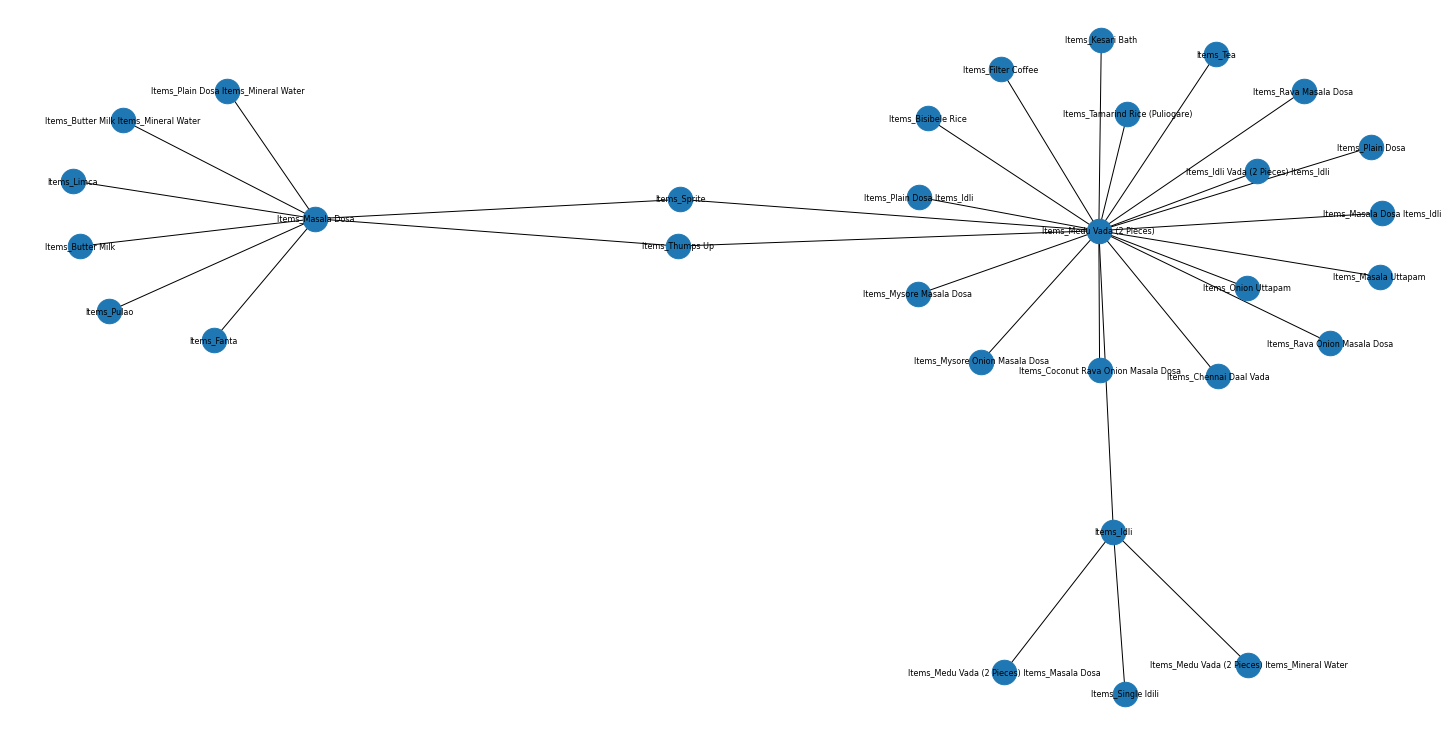

In [437]:
G=nx.Graph()
G.add_edges_from(asso_data)
print(nx.info(G))
plt.figure(5,figsize=(20,10)) 
nx.draw(G,with_labels = True,node_size=600,font_size=8)
plt.savefig("mdosa&idilivada_asso") # save as png
plt.show() 

# Visualizing for items which are most common.

#Insights

# People usually get something to drink with an item (Add beverage or juice with common food item eg. Lemon Crush)
# We can use this information of items ordered together to implements some ideas in the business for eg creating Combos 
#or # recommending customers by word of mouth that people usually take these items together

# Some Combo Samples:
#   Idili + Vada(Combo)
#   Masala Dosa+ Vada(Combo)
#   Any Dosa + Buttermilk/beverage/Juice (Combo)
#   Rice Item + Buttermilk/beverage/Juice(Combo)


In [438]:
list_xy=list_butter_m
for i in list_m_vada:
  list_xy.append(i)

Name: 
Type: Graph
Number of nodes: 33
Number of edges: 42
Average degree:   2.5455


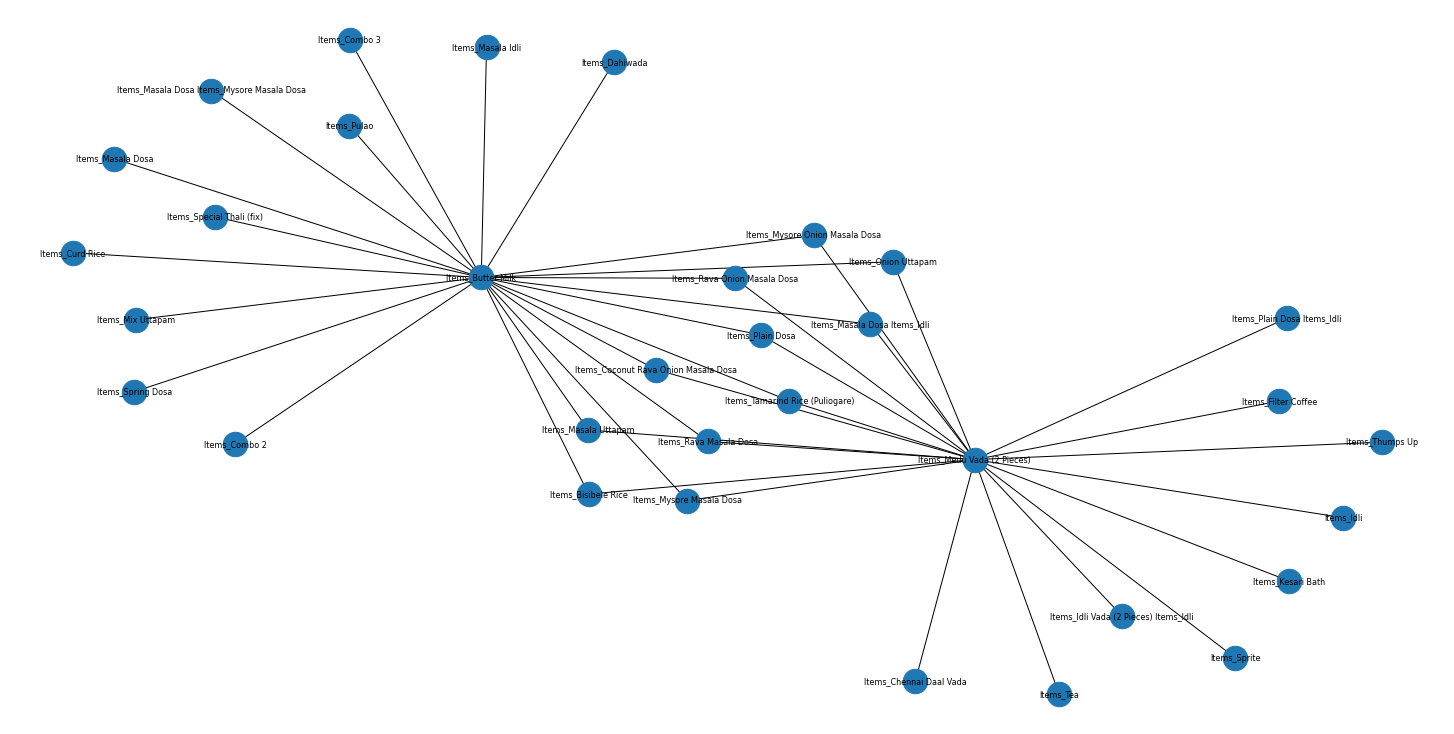

In [439]:
G=nx.Graph()
G.add_edges_from(list_xy)
print(nx.info(G))
plt.figure(5,figsize=(20,10)) 
nx.draw(G,with_labels = True,node_size=600,font_size=8)
plt.savefig("Vada&buttermilk_asso") # save as png
plt.show() 
# Visualization after removing mineral water

# After removing Item Mineral Water, we observe that Items Medu vada and Idili are often ordered with almost all type of other items.


## Data Visualizations

#### 1] Frequency of Items
- Plotting frequecny of items since they were added to the menu.
This visualization can tell us 
- Items that are popular
- Items that were ordered initially but their sales decreased and solutions can be implemented such as improving the item quality or promoting the item.
- Items that are a hit now which can be used to attract more customers by marketing it as a signature dish. 

In [440]:
item_freq_data.rename(columns={'Qty.':'Qty'},inplace=True)
item_freq_data.head()

,Items,year_month,Qty
0,Andhra Masala Dosa,2020-08,2
1,Andhra Masala Dosa,2020-09,1
2,Andhra Masala Dosa,2020-10,1
3,Andhra Masala Dosa,2020-11,1
4,Andhra Masala Dosa,2020-12,1


In [441]:
ab=item_freq_data.groupby(['Items','year_month']).agg({'Qty':'sum'})
ab.reset_index(inplace=True)
ab = ab.set_index(['Items','year_month']).sort_index()

In [442]:
ab_ust=ab.unstack()

In [443]:
ab_ust=ab_ust.groupby(['Items']).sum()
s1=ab_ust.stack()
s1.head()

Qty
Items              year_month     
Andhra Masala Dosa 2020-08     2.0
                   2020-09     1.0
                   2020-10     1.0
                   2020-11     1.0
                   2020-12     1.0

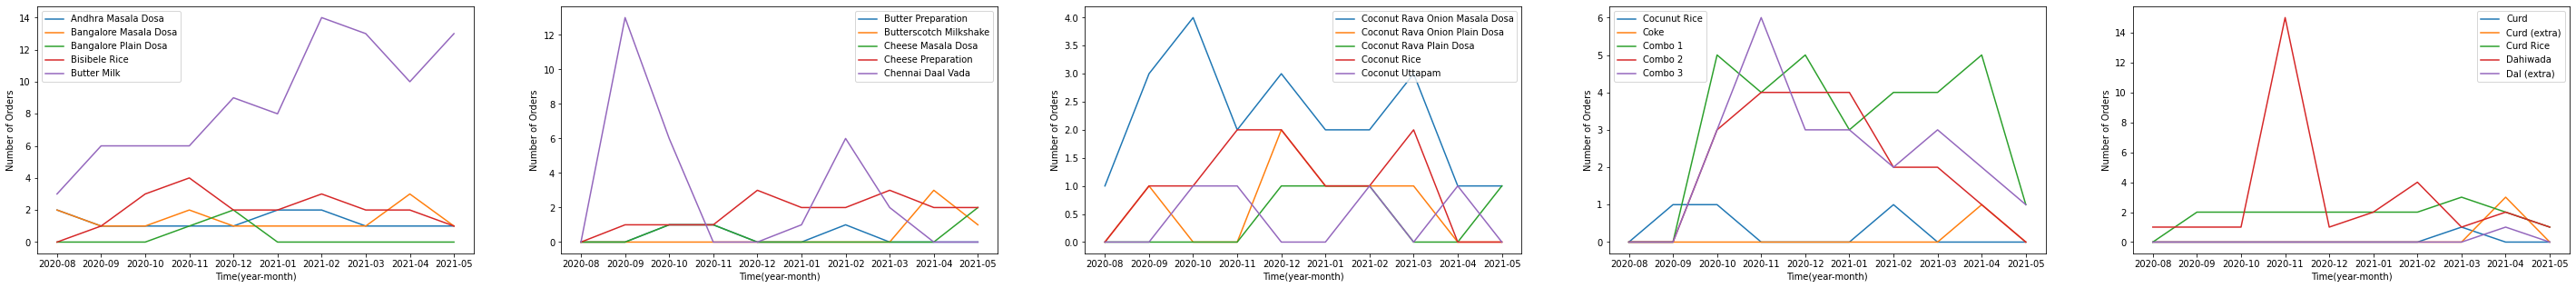

In [444]:
# Monthly Frequency of Items

# From the following Graphs we can observe Popularity of Which Items are decreased with time and increased for which items.

#First 25 items
itm=list(item_freq_data['Items'].unique())
warnings.filterwarnings("ignore")
alpha=151
plt.figure(figsize=(50,5))

ind1= 0
ind2= 5

for j in range(alpha,alpha+5):
  for i in itm[ind1:ind2]:
    plt.subplot(j)
    data = s1.loc[i]
    plt.plot(data.index, data.values)
    plt.legend(itm[ind1:ind2]) 
    plt.xlabel('Time(year-month)')
    plt.ylabel('Number of Orders')
  ind1+=5
  ind2+=5
  if ind2 >25:
    break

# Insights Gained:-

# Significaant Increase: Butter Milk,
# Significant Decrease:Combo 3, Combo 2


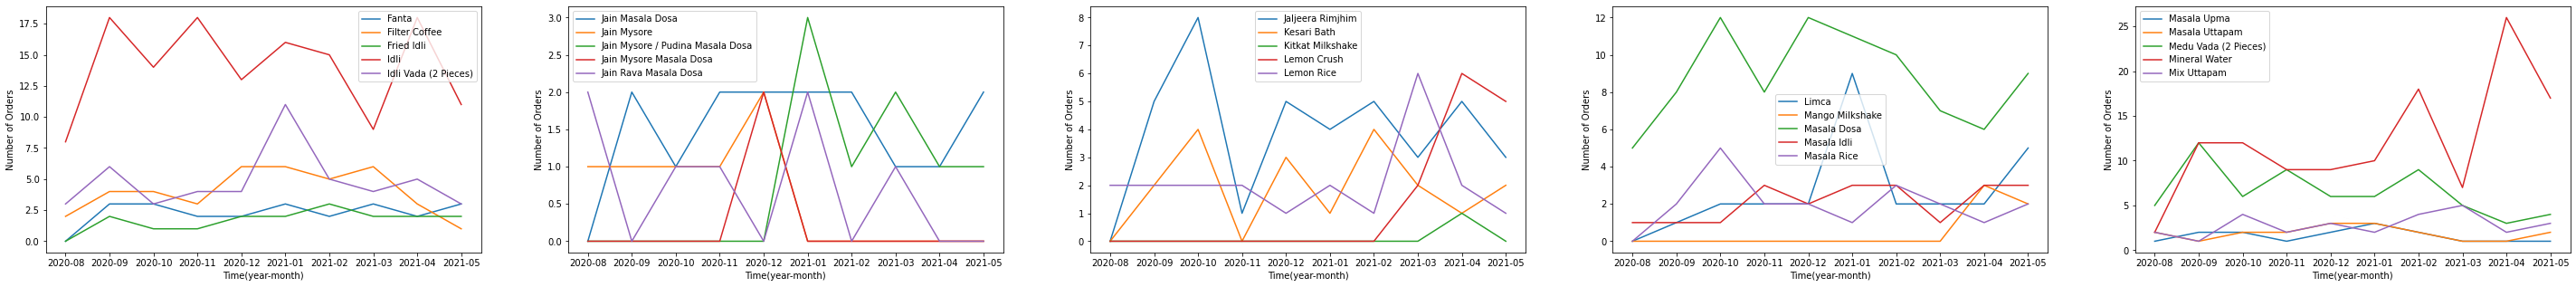

In [445]:
# Next 25 Items
alpha=151
plt.figure(figsize=(50,5))

ind1= 25
ind2= 30

for j in range(alpha,alpha+5):
  for i in itm[ind1:ind2]:
    plt.subplot(j)
    data = s1.loc[i]
    plt.plot(data.index, data.values)
    plt.legend(itm[ind1:ind2]) 
    plt.xlabel('Time(year-month)')
    plt.ylabel('Number of Orders')
  ind1+=5
  ind2+=5
  if ind2 >50:
    break

# Insights Gained:-

# Significaant Increase: Lemon Crush
# Significant Decrease:Medu Vada(Since Feburary)
# Idili and Masala Dosa is all time popular Item


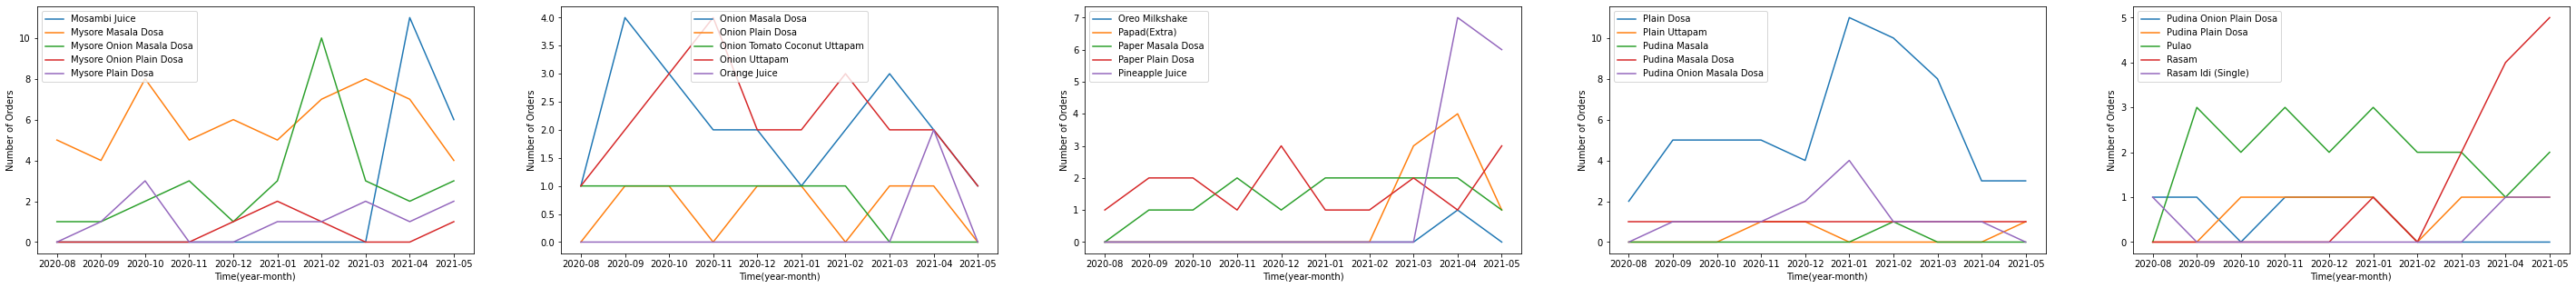

In [446]:
# Next 25 Items
alpha=151
plt.figure(figsize=(50,5))

ind1= 50
ind2= 55

for j in range(alpha,alpha+5):
  for i in itm[ind1:ind2]:
    plt.subplot(j)
    data = s1.loc[i]
    plt.plot(data.index, data.values)
    plt.legend(itm[ind1:ind2]) 
    plt.xlabel('Time(year-month)')
    plt.ylabel('Number of Orders')
  ind1+=5
  ind2+=5
  if ind2 >75:
    break
    
# Insights Gained:-

# Significaant Increase: Rasam
# Significant Decrease:Plain Dosa(Since January)
# Mysore Masala Dosa is all time popular Item

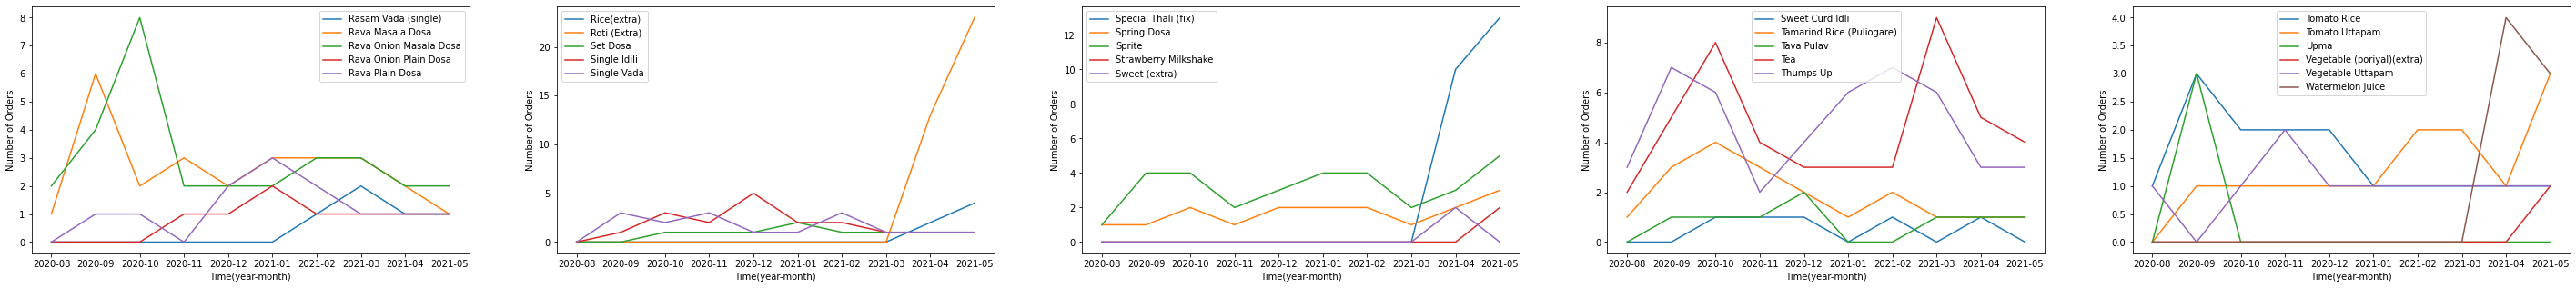

In [447]:
# Remaining Items
alpha=151
plt.figure(figsize=(50,5))

ind1= 75
ind2= 80

for j in range(alpha,alpha+5):
  if ind2==100:
    ind2=101
  for i in itm[ind1:ind2]:
    plt.subplot(j)
    data = s1.loc[i]
    plt.plot(data.index, data.values)
    plt.legend(itm[ind1:ind2]) 
    plt.xlabel('Time(year-month)')
    plt.ylabel('Number of Orders')
  ind1+=5
  ind2+=5

# Insights Gained:-

# Significaant Increase: Tea, Cold Drinks(Limca, Sprite Thumps Up)
# Significant Decrease: Rava Masala Dosa
# Roti and Special Thali is all time popular Item since March2021


# We can also check out the all time unpopular items and try to increase sales on those items by applying offers.

#### 2] Category Wise Distribution of Items
 To show in each category which Item sells the best.

In [448]:
categorywise_performance['Category'].unique()

array(['Beverages', 'Uttapam', 'Idli', 'Rice', 'Extra', 'Dosa', 'Total'],
      dtype=object)

In [449]:
# Data for plots

bev=categorywise_performance[categorywise_performance['Category']=='Beverages']
utt=categorywise_performance[categorywise_performance['Category']=='Uttapam']
idi=categorywise_performance[categorywise_performance['Category']=='Idli']
rice=categorywise_performance[categorywise_performance['Category']=='Rice']
extra=categorywise_performance[categorywise_performance['Category']=='Extra']
dosa=categorywise_performance[categorywise_performance['Category']=='Dosa']

Text(0, 0.5, 'Quantity of Items')

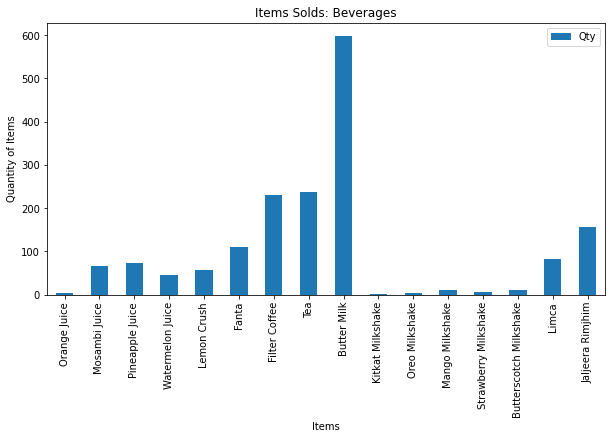

In [450]:
# Quantity of Beverage Category according to each item


bev.plot(x="Item", y="Qty", kind="bar",figsize=(10, 5))
plt.title('Items Solds: Beverages')
plt.xlabel('Items')
plt.ylabel('Quantity of Items')


Text(0, 0.5, 'Quantity of Items')

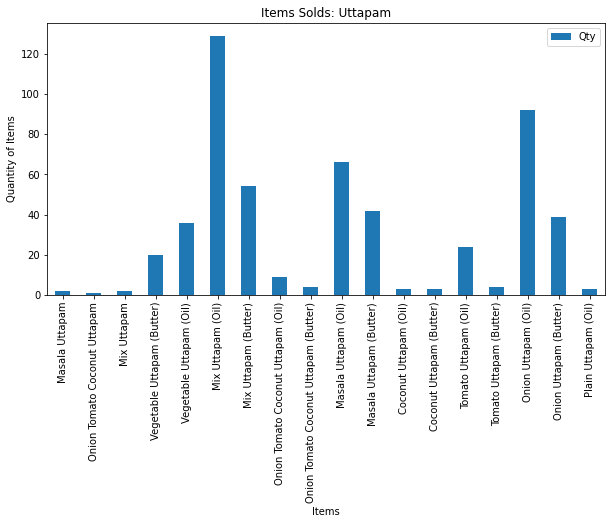

In [451]:
# Quantity of Uttapam Category according to each item

utt.plot(x="Item", y="Qty", kind="bar",figsize=(10, 5))
plt.title('Items Solds: Uttapam')
plt.xlabel('Items')
plt.ylabel('Quantity of Items')

Text(0, 0.5, 'Quantity of Items')

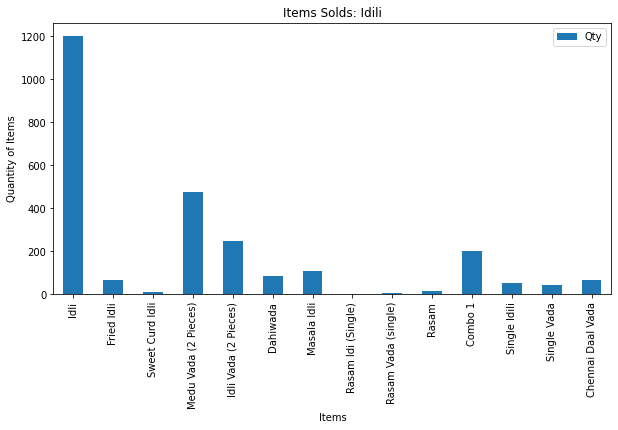

In [452]:
# Quantity of Idili Category according to each item

idi.plot(x="Item", y="Qty", kind="bar",figsize=(10, 5))
plt.title('Items Solds: Idili')
plt.xlabel('Items')
plt.ylabel('Quantity of Items')

Text(0, 0.5, 'Quantity of Items')

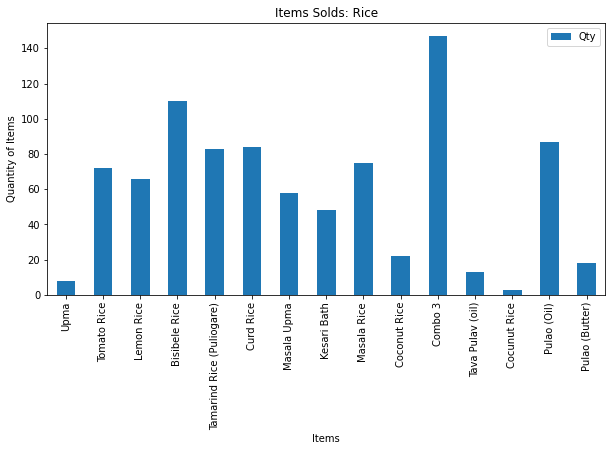

In [453]:
# Quantity of Rice Category according to each item

rice.plot(x="Item", y="Qty", kind="bar",figsize=(10, 5))
plt.title('Items Solds: Rice')
plt.xlabel('Items')
plt.ylabel('Quantity of Items')

Text(0, 0.5, 'Quantity of Items')

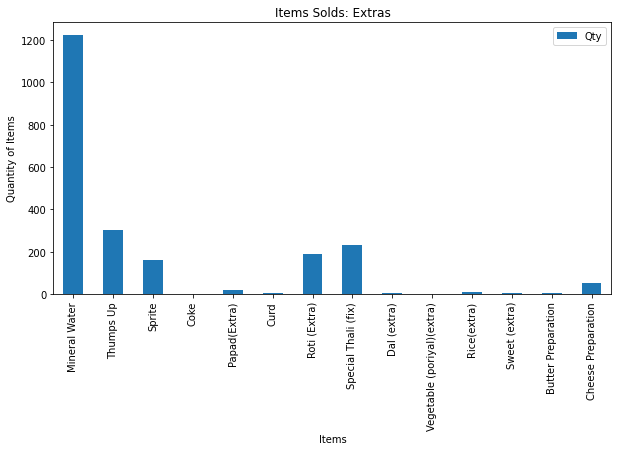

In [454]:
# Quantity of Extras Category according to each item

extra.plot(x="Item", y="Qty", kind="bar",figsize=(10, 5))
plt.title('Items Solds: Extras')
plt.xlabel('Items')
plt.ylabel('Quantity of Items')

Text(0, 0.5, 'Quantity of Items')

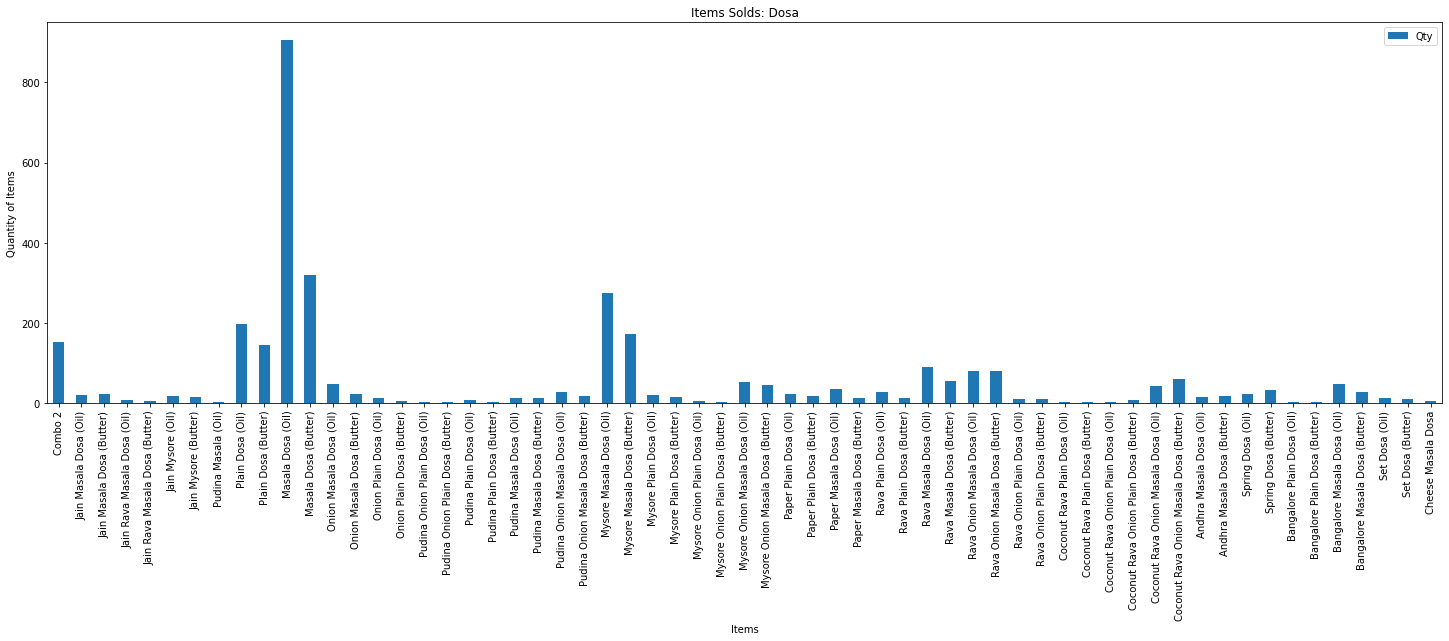

In [455]:
# Quantity of Dosa Category according to each item

dosa.plot(x="Item", y="Qty", kind="bar",figsize=(25,7))
plt.title('Items Solds: Dosa')
plt.xlabel('Items')
plt.ylabel('Quantity of Items')

#### 3] Number of Lunch time and Dinner time Orders

In [456]:
order_data.head()

,Invoice,Final Total,Date_and_time,Date,Hour_of_Day,Weekday,Meal_type
0,26.0,525.00,2020-08-10 19:53:29,2020-08-10,19,Monday,Dinner
1,27.0,324.00,2020-08-10 19:57:51,2020-08-10,19,Monday,Dinner
2,28.0,500.00,2020-08-10 20:00:38,2020-08-10,20,Monday,Dinner
3,29.0,301.75,2020-08-10 20:06:07,2020-08-10,20,Monday,Dinner
4,30.0,45.00,2020-08-10 20:23:19,2020-08-10,20,Monday,Dinner


Text(0, 0.5, 'Numbers of Orders')

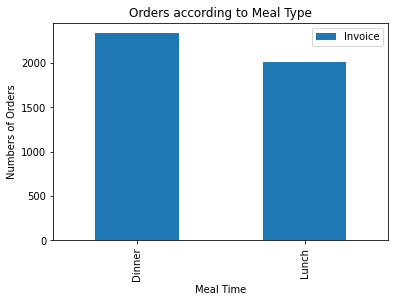

In [457]:
order_data.groupby('Meal_type').agg({'Invoice':'count'}).plot.bar()
plt.title('Orders according to Meal Type')
plt.xlabel('Meal Time')
plt.ylabel('Numbers of Orders')

#### 4] Orders Per Day Visualization

Text(0, 0.5, 'Numbers of Orders')

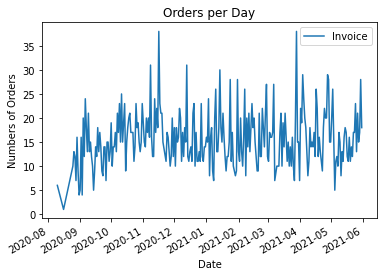

In [458]:

order_data.groupby('Date').agg({'Invoice':'count'}).plot()
plt.title('Orders per Day')
plt.xlabel('Date')
plt.ylabel('Numbers of Orders')

# Counting number of invoices and group by date

#### 5] Daily Order Frequency

To know at what time of the date orders are more.

Text(0, 0.5, 'Numbers of Orders')

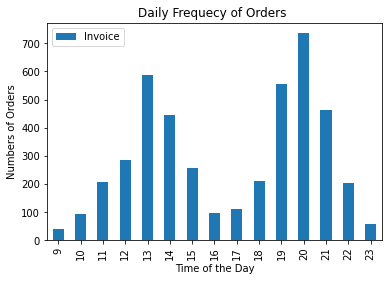

In [459]:
order_data.groupby('Hour_of_Day').agg({'Invoice':'count'}).plot.bar()
plt.title('Daily Frequecy of Orders ')
plt.xlabel('Time of the Day')
plt.ylabel('Numbers of Orders')

#### 6] Frequency of Online Orders

To know at what time of the day there are more onilne orders.

Text(0, 0.5, 'Numbers of Onilne Orders')

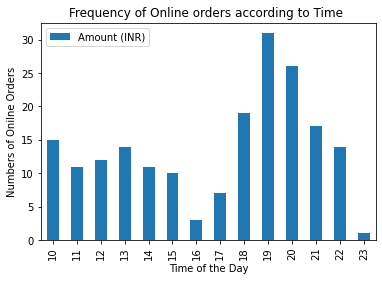

In [460]:
completed_orders_online.groupby('Hour').agg({'Amount (INR)':'count'}).plot.bar()
plt.title('Frequency of Online orders according to Time ')
plt.xlabel('Time of the Day')
plt.ylabel('Numbers of Onilne Orders')

## Time Series Sales Forecasting
- Less data is available as this is a new restaurant.
- Simple forecasting techniques are used because a lot of external factors are involved in new business and also data is less.

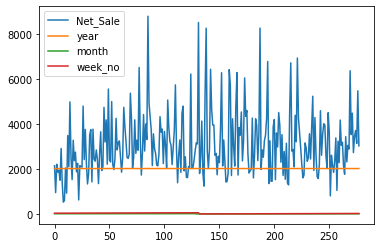

In [121]:
Total_Sales.plot()

In [122]:
Total_Sales.shape

(278, 6)

In [123]:
Original_total_sales=Total_Sales.copy()

In [124]:
ts_date=Total_Sales['Orders Date']
ts_year=[ts_date[i].year for i in range(278)]
ts_month=[ts_date[i].month for i in range(278)]
ts_week_no=[ts_date[i].isocalendar()[1] for i in range(278)]
ts_dayofweek=[calendar.day_name[ts_date[i].weekday()] for i in range(278)]

Total_Sales['year']=ts_year
Total_Sales['month']=ts_month
Total_Sales['week_no']=ts_week_no
Total_Sales['dayofweek']=ts_dayofweek

# Adding various time coulumns

In [125]:
Total_Sales.head(10)

,Orders Date,Net_Sale,year,month,week_no,dayofweek
0,2020-08-10,2146.0,2020,8,33,Monday
1,2020-08-16,950.0,2020,8,33,Sunday
2,2020-08-25,2211.0,2020,8,35,Tuesday
3,2020-08-26,1863.0,2020,8,35,Wednesday
4,2020-08-27,1939.0,2020,8,35,Thursday
5,2020-08-28,1501.0,2020,8,35,Friday
6,2020-08-29,2916.0,2020,8,35,Saturday
7,2020-08-30,1368.0,2020,8,35,Sunday
8,2020-08-31,525.0,2020,8,36,Monday
9,2020-09-01,600.0,2020,9,36,Tuesday


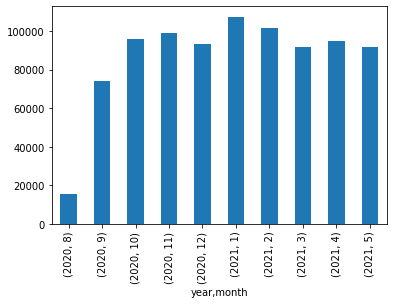

In [126]:
Total_Sales.groupby(['year','month'])['Net_Sale'].sum().plot.bar()

# Monthly sales data

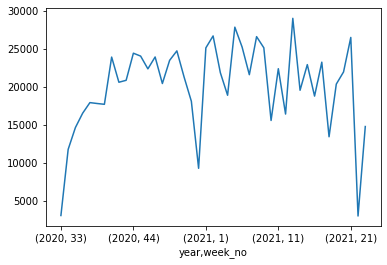

In [127]:
week_grp=Total_Sales.groupby(['year','week_no'])['Net_Sale'].sum()
week_grp.plot()
week_grp=week_grp.reset_index()

# Weekly Sales Data

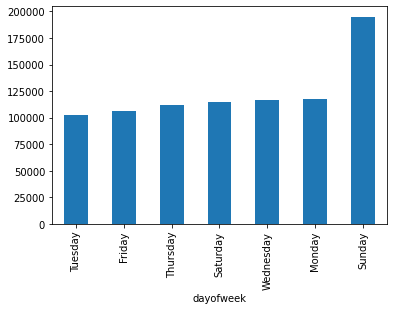

In [128]:
#Sales according to Day of the Week
sale_dow=Total_Sales.groupby('dayofweek')['Net_Sale'].sum()
sale_dow_sorted=sale_dow.sort_values()
sale_dow_sorted.plot.bar()

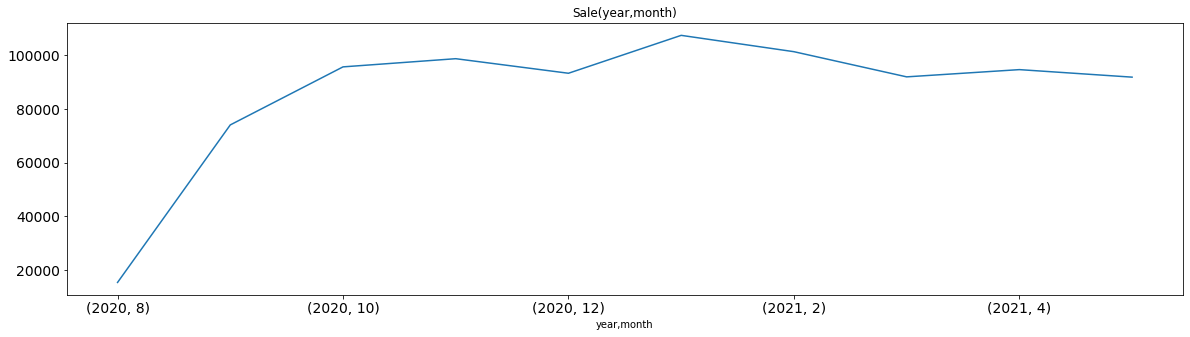

In [129]:
sale=Total_Sales.groupby(['year','month'])['Net_Sale'].sum()
sale.plot(figsize=(20,5),title='Sale(year,month)',fontsize=14)
#Monthly sales

In [130]:
# Check id data is sationary for Arima model
def test_stationarity(timeseries):
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)


test_stationarity(Total_Sales['Net_Sale'])

Results of Dickey-Fuller Test:
Test Statistic                  -4.660746
p-value                          0.000100
#Lags Used                       6.000000
Number of Observations Used    271.000000
Critical Value (1%)             -3.454713
Critical Value (5%)             -2.872265
Critical Value (10%)            -2.572485
dtype: float64


In [131]:
Total_Sales[217:]

,Orders Date,Net_Sale,year,month,week_no,dayofweek
217,2021-03-31,2871.0,2021,3,13,Wednesday
218,2021-04-01,2092.0,2021,4,13,Thursday
219,2021-04-02,4391.0,2021,4,13,Friday
220,2021-04-03,3215.0,2021,4,13,Saturday
221,2021-04-04,6942.0,2021,4,13,Sunday
...,...,...,...,...,...,...
273,2021-05-27,3440.0,2021,5,21,Thursday
274,2021-05-28,3717.0,2021,5,21,Friday
275,2021-05-29,3138.0,2021,5,21,Saturday
276,2021-05-30,5481.0,2021,5,21,Sunday


In [132]:
train=Total_Sales[0:248]
valid=Total_Sales[248:278]

In [133]:
valid.head()

,Orders Date,Net_Sale,year,month,week_no,dayofweek
248,2021-05-01,2024.0,2021,5,17,Saturday
249,2021-05-02,4505.0,2021,5,17,Sunday
250,2021-05-03,3656.0,2021,5,18,Monday
251,2021-05-05,805.0,2021,5,18,Wednesday
252,2021-05-06,2613.0,2021,5,18,Thursday
253,2021-05-07,2170.0,2021,5,18,Friday
254,2021-05-08,1850.0,2021,5,18,Saturday
255,2021-05-09,2362.0,2021,5,18,Sunday
256,2021-05-10,3384.0,2021,5,19,Monday
257,2021-05-11,1049.0,2021,5,19,Tuesday


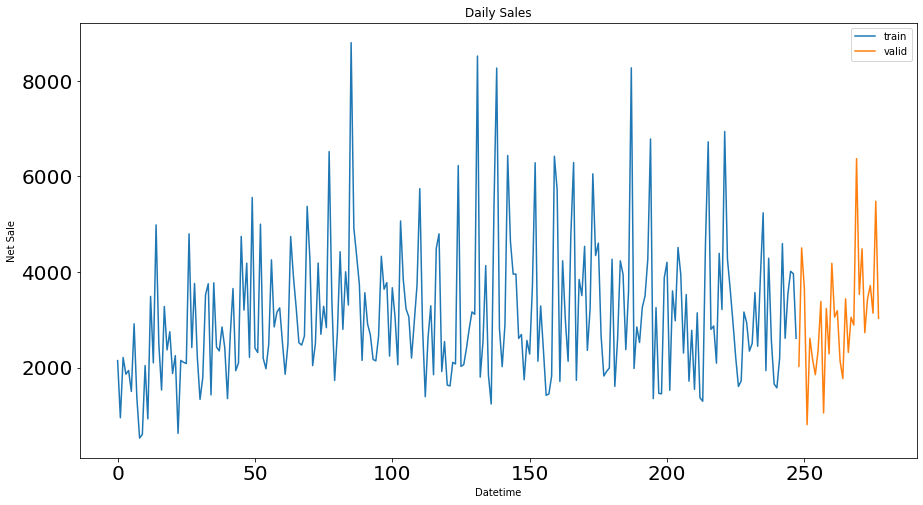

In [134]:
train.Net_Sale.plot(figsize=(15,8),title='Daily Sales',fontsize=20,label='train')
valid.Net_Sale.plot(figsize=(15,8),title='Daily Sales',fontsize=20,label='valid')
plt.xlabel('Datetime')
plt.ylabel('Net Sale')
plt.legend(loc='best')
plt.show()

### Simple Exponential Smoothing
- This is a restaurant business,so SES seems a good fit as recent sales are more pertinent.
- Average of 3118 per day. (Accoring to prediction)
- This model fit the best among various models including arima.

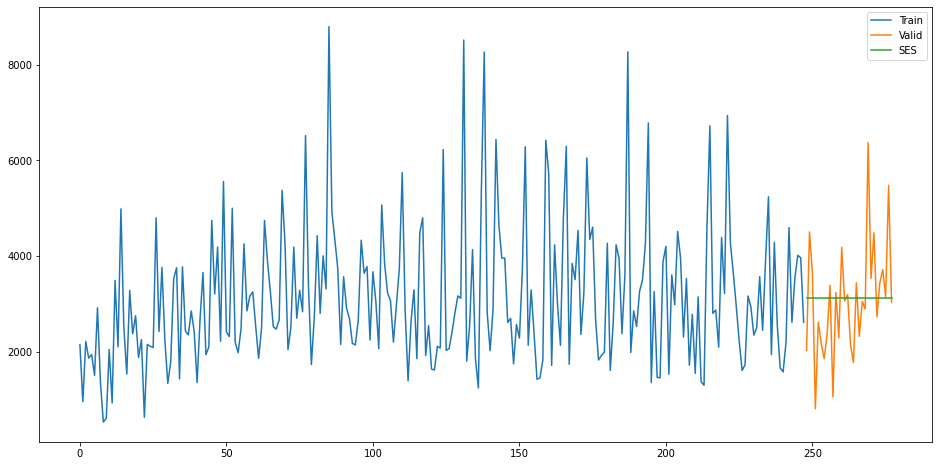

In [135]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg=valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Net_Sale'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(16,8))
plt.plot(train['Net_Sale'], label='Train') 
plt.plot(valid['Net_Sale'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best')
plt.show()